In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from scipy import interpolate 

import surfinBH

In [14]:
#Pick the fit
fitOpt = list(surfinBH.fits_collection.keys())
print(fitOpt)

[surfinBH.fits_collection[fit].desc for fit in fitOpt]

['NRSur3dq8Remnant', 'surfinBH7dq2', 'NRSur7dq4Remnant']


['Fits for remnant mass, spin and kick veclocity for nonprecessing BBH systems. This model was called surfinBH3dq8 in the paper.',
 'Fits for remnant mass, spin and kick veclocity for generically precessing BBH systems.',
 'Fits for remnant mass, spin and kick veclocity for generically precessing BBH systems up to mass ratio 4.']

In [ ]:
fit = surfinBH.LoadFits(fit_name)

1.0


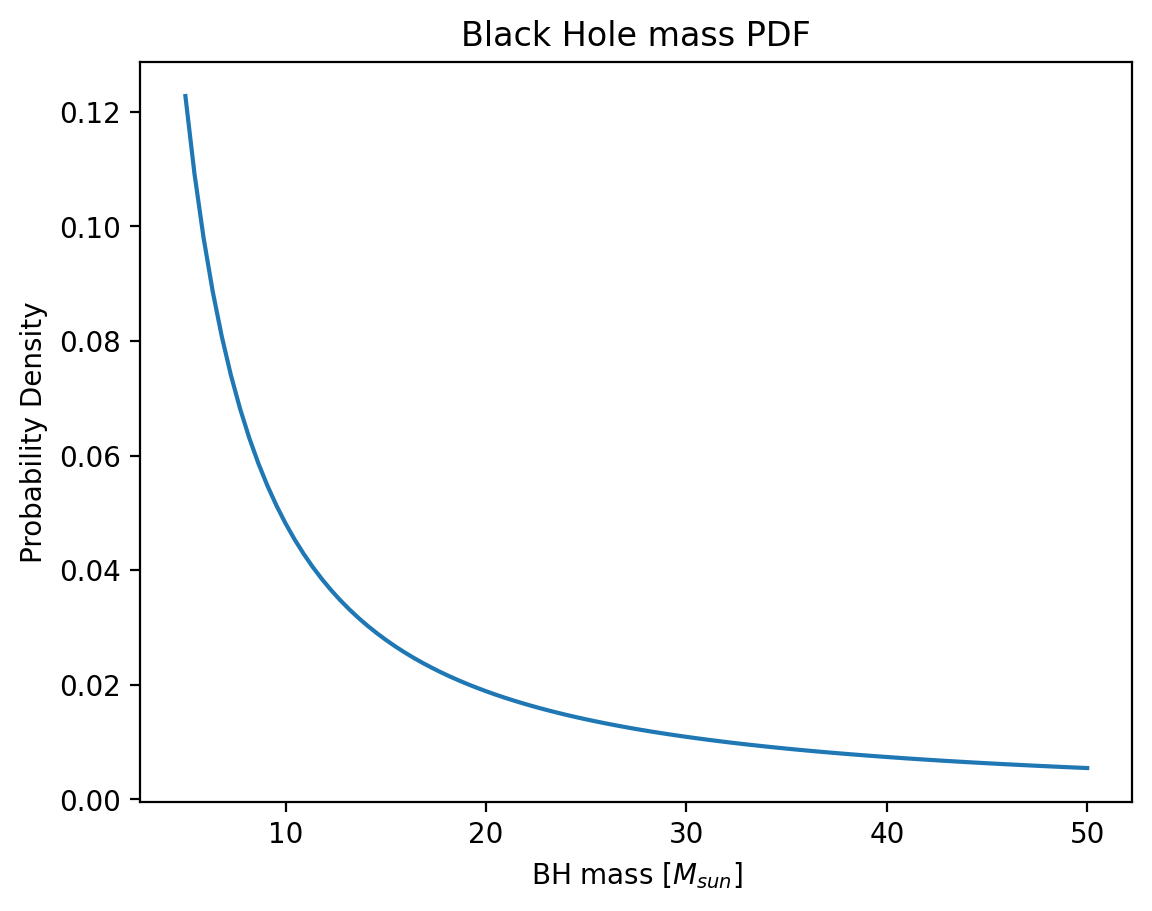

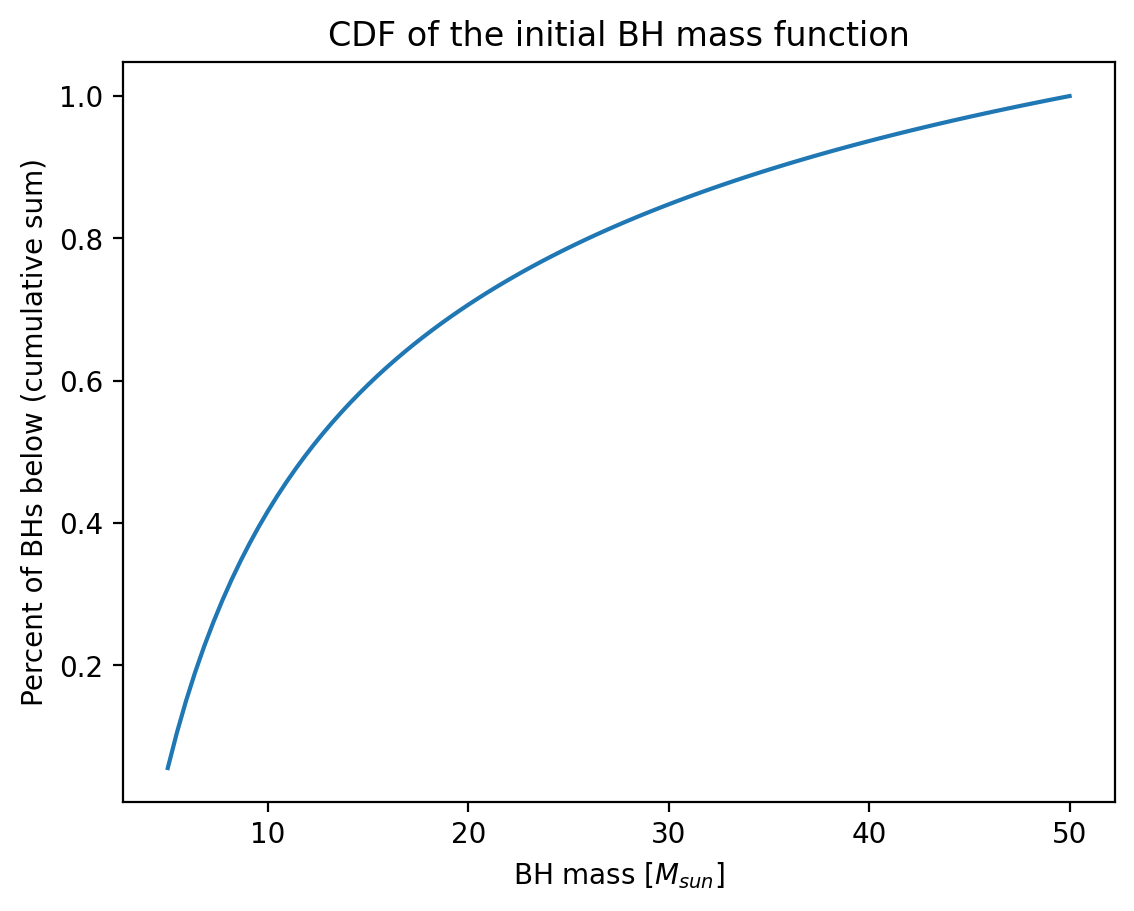

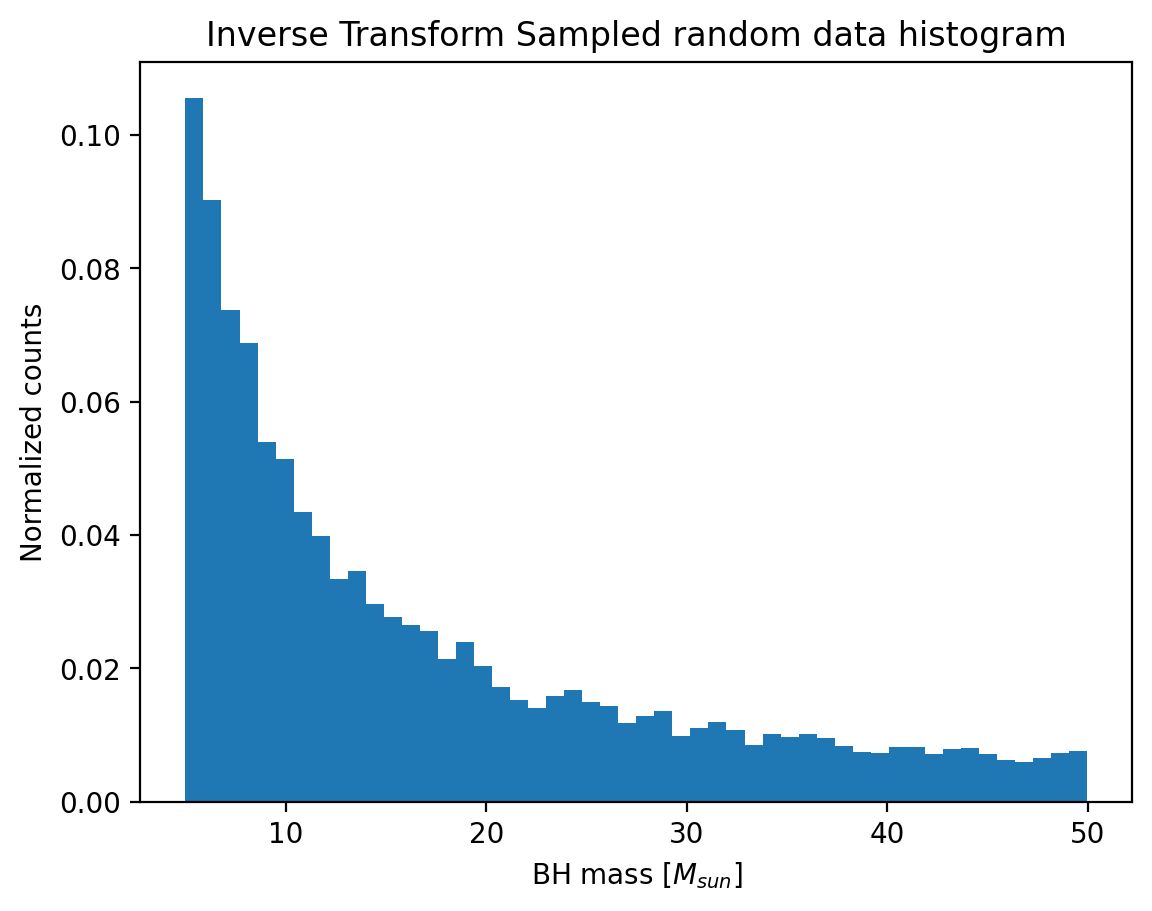

In [68]:
mdist = np.linspace(5,50,100)
dm = mdist[1]-mdist[0]

#Use initial mass function (integral form) 
#to get PDF of BH masses
ndist = mdist**-1.35
ndist = ndist/sum(ndist*dm)
print(sum(ndist*dm))

plt.title('Black Hole mass PDF')
plt.plot(mdist,ndist)
plt.xlabel('BH mass [$M_{sun}$]')
plt.ylabel('Probability Density')
plt.show()


#Turn this into a CDF
cdf = np.cumsum(ndist)/np.sum(ndist)
plt.title('CDF of the initial BH mass function')
plt.plot(mdist,cdf)
plt.xlabel('BH mass [$M_{sun}$]')
plt.ylabel('Percent of BHs below (cumulative sum)')
plt.show()

#Use inverse transform sampling, get a weighted distribution
#from a uniform distribution
invTranSamp = scipy.interpolate.interp1d(cdf, mdist)

u = np.random.uniform(min(cdf),max(cdf), 10000) 
sampled_m = invTranSamp(u)

plt.title('Inverse Transform Sampled random data histogram')
plt.hist(sampled_m, bins=50, density=True)
plt.xlabel('BH mass [$M_{sun}$]')
plt.ylabel('Normalized counts')
plt.show()